# Louis Massera

In [469]:
%matplotlib inline
% load_ext autoreload
% autoreload 2
import numpy as np
import pandas as pd
from scipy.io import loadmat
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram, ward, fcluster
from scipy.cluster.hierarchy import dendrogram
from sklearn.metrics import average_precision_score, 
                            roc_auc_score, silhouette_score, 
                            silhouette_samples, adjusted_rand_score, 
                            normalized_mutual_info_score
from sklearn.base import clone
from sklearn.utils import check_random_state
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV

# Task 1

## 1)

In [2]:
mat = loadmat('annthyroid.mat')

In [3]:
X = mat['X']
Y = mat['y']

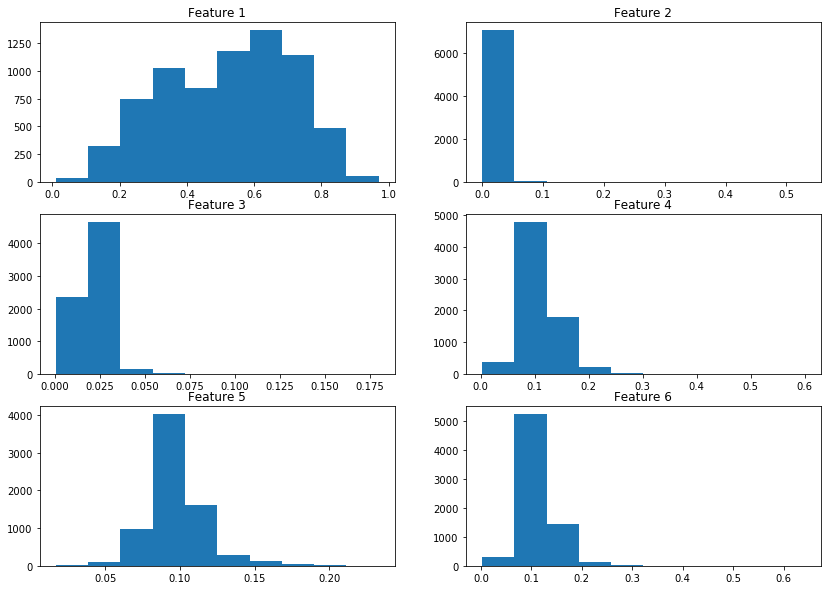

In [468]:
fig, axes = plt.subplots(3, 2, figsize=(14, 10))
for i, ax in enumerate(axes.ravel()):
    if i > 5:
        continue
    ax.hist(X[:, i])
    ax.set_title("Feature {}".format(i+1))
plt.show()

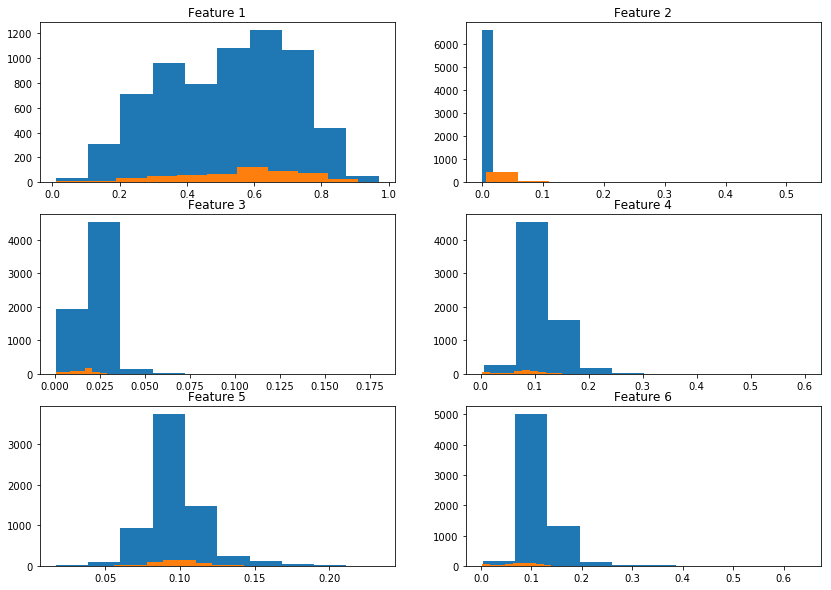

In [465]:
fig, axes = plt.subplots(3, 2, figsize=(14, 10))
for i, ax in enumerate(axes.ravel()):
    if i > 5:
        continue
    ax.hist(X[np.where(Y==0)[0]][:, i])
    ax.hist(X[np.where(Y==1)[0]][:, i])
    ax.set_title("Feature {}".format(i+1))
plt.show()

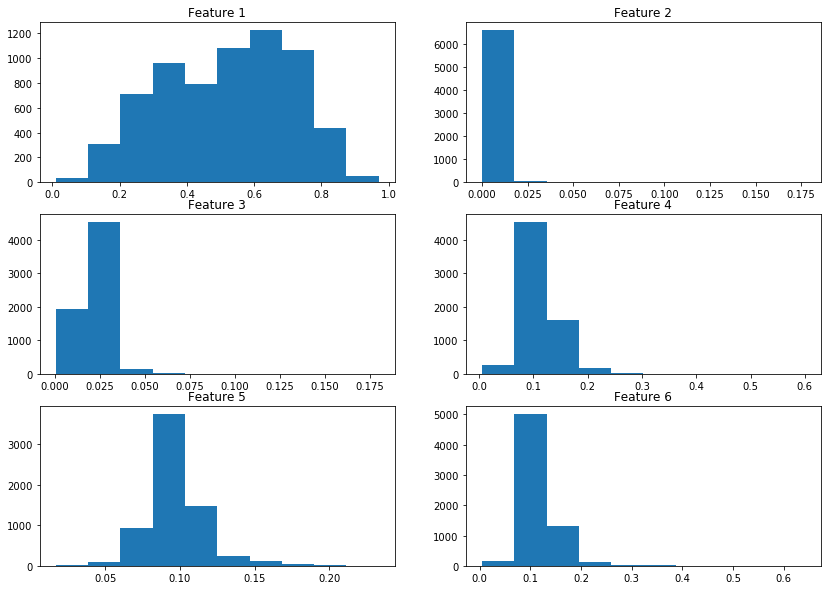

In [491]:
fig, axes = plt.subplots(3, 2, figsize=(14, 10))
for i, ax in enumerate(axes.ravel()):
    if i > 5:
        continue
    ax.hist(X[np.where(Y==0)[0]][:, i])
    ax.set_title("Feature {}".format(i+1))
plt.show()

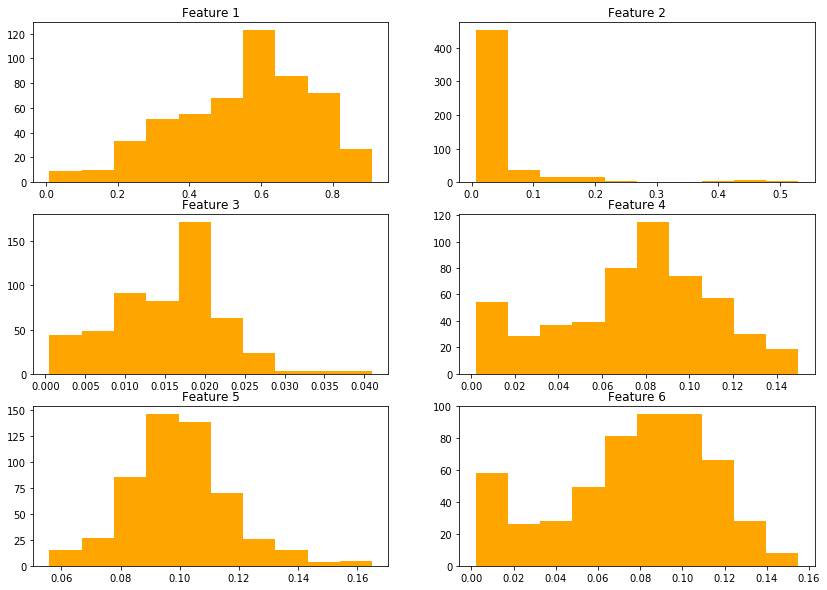

In [490]:
fig, axes = plt.subplots(3, 2, figsize=(14, 10))
for i, ax in enumerate(axes.ravel()):
    if i > 5:
        continue
    ax.hist(X[np.where(Y==1)[0]][:, i],color='orange')
    ax.set_title("Feature {}".format(i+1))
plt.show()

We notice that the dataset is unbalanced in favor of inliers. Still, we can see some differences between univariate distributions of features of outliers and inliers. For instance on feature 2, where outliers seem to have a higher mean than inliers.  

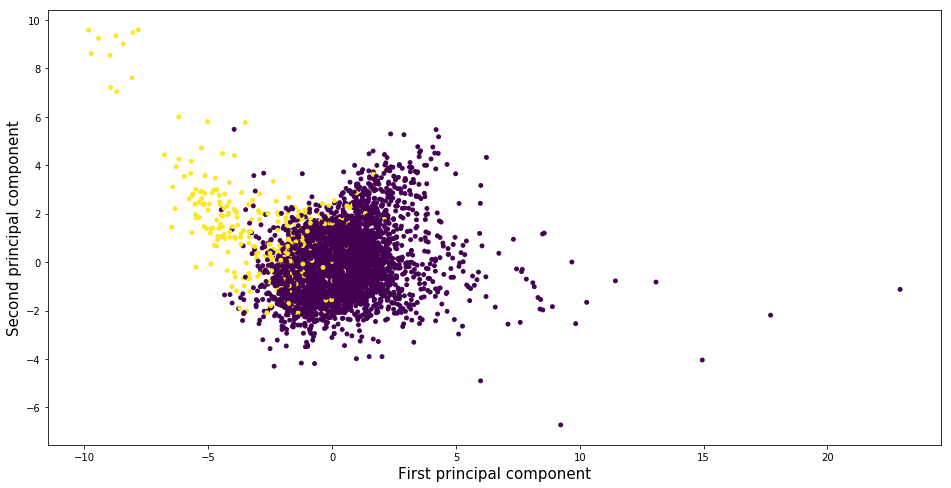

In [442]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(16,8))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=Y, s=15)
plt.xlabel("First principal component", fontsize=15)
plt.ylabel("Second principal component", fontsize=15)
plt.show()

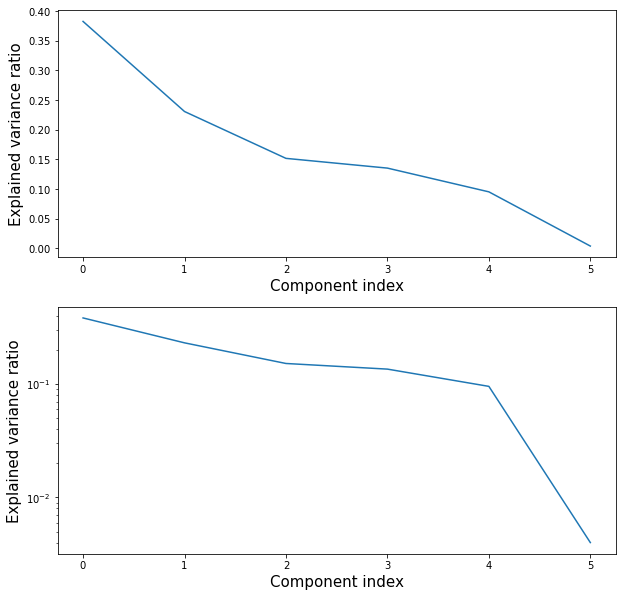

In [474]:
fig, axes = plt.subplots(2, figsize=(10,10))
axes[0].plot(pca.explained_variance_ratio_)
axes[1].semilogy(pca.explained_variance_ratio_)
for ax in axes:
    ax.set_xlabel("Component index", fontsize=15)
    ax.set_ylabel("Explained variance ratio", fontsize=15)

In [492]:
pca.explained_variance_ratio_

array([ 0.38261537,  0.2307925 ,  0.1518097 ,  0.13539672,  0.09538214,
        0.00400357])

If we wanted to reduce the dimensionality of data to compress it, a good threshold for the number of principal components would be 2, because from 2 to 4 principal components, the gain in explained variance is small compared to the one when moving from 4 to 5 principal components. 

# 2)

In [445]:
%%time
X_tsne = TSNE().fit_transform(X_scaled)

CPU times: user 3min 24s, sys: 22.3 s, total: 3min 46s
Wall time: 3min 51s


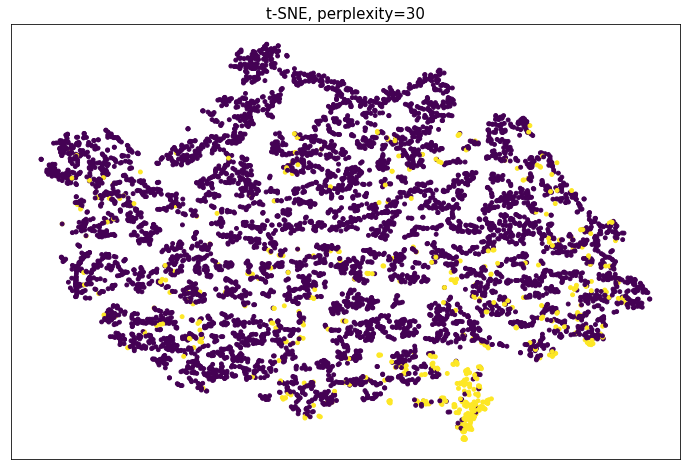

In [455]:
plt.figure(figsize=(12,8))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=Y, s=15)
plt.xticks(())
plt.yticks(())
plt.title("t-SNE, perplexity=30", fontsize=15)
plt.show()

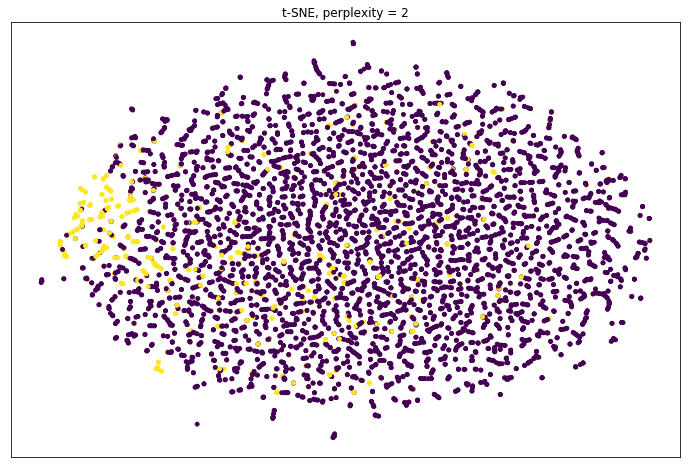

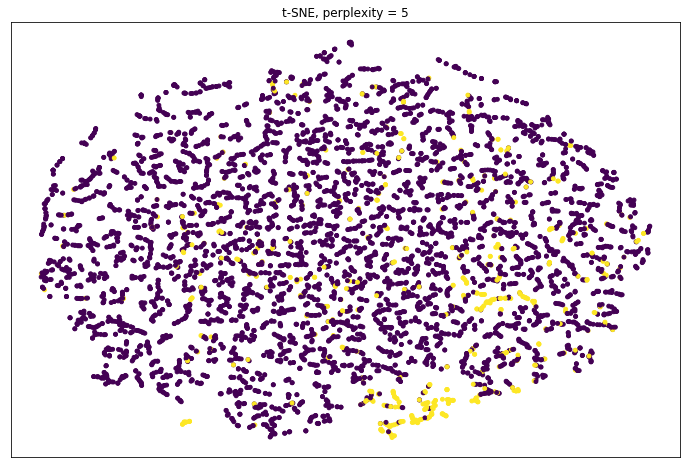

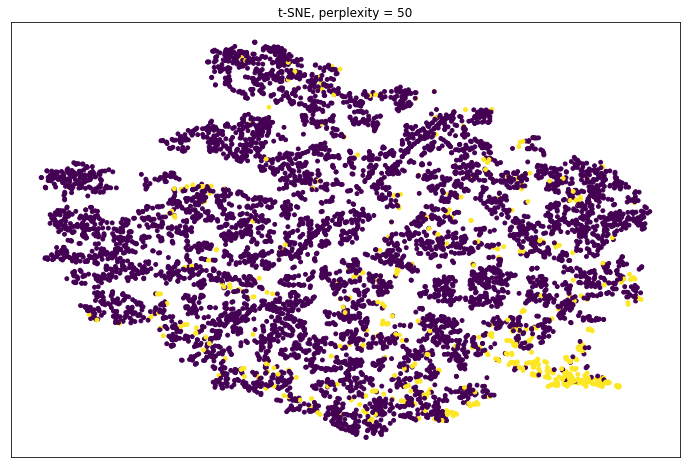

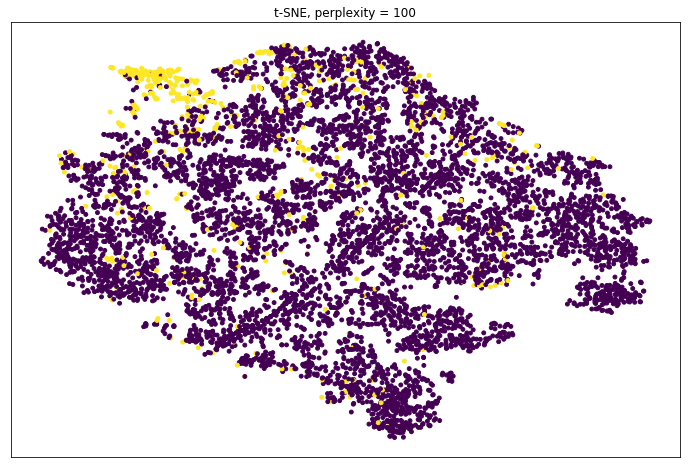

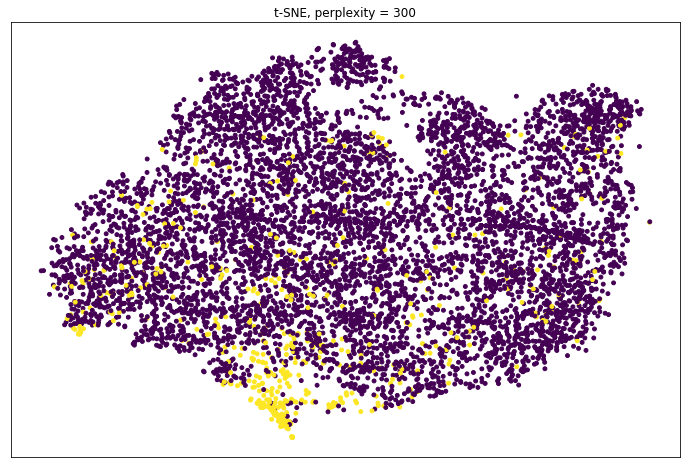

CPU times: user 30min 10s, sys: 2min 9s, total: 32min 20s
Wall time: 32min 41s


In [456]:
%%time
for perplexity in [2, 5, 50, 100, 300]:
    plt.figure(figsize=(12,8))
    plt.xticks(())
    plt.yticks(())
    X_tsne = TSNE(perplexity=perplexity).fit_transform(X_scaled)
    plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=Y, s=15)
    plt.title("t-SNE, perplexity = {}".format(perplexity))
    plt.show()

Tuning the perplexity parameter does not seem to help obtaining a better data visualization. What is different between these visualisations is the location of the main amount of outliers.

# Task 2

I used silhouette_plot and cluster_stability, two functions from class.

In [68]:
def silhouette_plot(X, cluster_labels, ax=None):
    silhouette_scores = silhouette_samples(X, cluster_labels)
    if ax is None:
        ax = plt.gca()
    y_lower = 10
    inliers = cluster_labels != -1
    X = X[inliers]
    cluster_labels = cluster_labels[inliers]
    silhouette_scores = silhouette_scores[inliers]
    labels = np.unique(cluster_labels)
    cm = plt.cm.Vega10 if len(labels) <= 10 else plt.cm.Vega20
    for i in labels:
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            silhouette_scores[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm(i)
        ax.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

In [69]:
def cluster_stability(X, est, n_iter=20, random_state=None):
    labels = []
    indices = []
    for i in range(n_iter):
        # draw bootstrap samples, store indices
        sample_indices = rng.randint(0, X.shape[0], X.shape[0])
        indices.append(sample_indices)
        est = clone(est)
        if hasattr(est, "random_state"):
            # randomize estimator if possible
            est.random_state = rng.randint(1e5)
        X_bootstrap = X[sample_indices]
        est.fit(X_bootstrap)
        # store clustering outcome using original indices
        relabel = -np.ones(X.shape[0], dtype=np.int)
        relabel[sample_indices] = est.labels_
        labels.append(relabel)
    scores = []
    for l, i in zip(labels, indices):
        for k, j in zip(labels, indices):
            # we also compute the diagonal which is a bit silly
            in_both = np.intersect1d(i, j)
            scores.append(adjusted_rand_score(l[in_both], k[in_both]))
    return np.mean(scores)

## 1)

### K-means

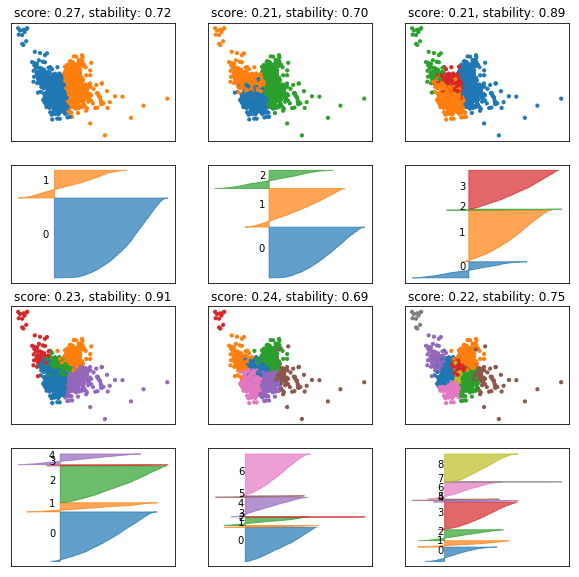

In [494]:
fig, axes = plt.subplots(4, 3, subplot_kw={'xticks': (), 'yticks':()}, figsize=(10, 10))
axes = np.hstack([axes[:2], axes[2:]]).T
for ax, i in zip(axes, [2,3,4,5,7,9]):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(X_scaled)
    ax[0].scatter(X_pca[:, 0], X_pca[:, 1], c=plt.cm.Vega10(kmeans.labels_), s=10)
    silhouette_plot(X_scaled, kmeans.labels_, ax=ax[1])
    ax[0].set_title("score: {:.2f}, stability: {:.2f}".format(silhouette_score(X_scaled, 
                                                                               kmeans.labels_), 
                     cluster_stability(X_scaled, KMeans(n_clusters=i, n_init=10), n_iter=20)))

In [495]:
L_stab = []
L_sil = []
n_cluster = np.arange(2, 10, 1)
for i in n_cluster:
    kmeans = KMeans(n_clusters=i)
    L_stab.append(cluster_stability(X_scaled, kmeans))
    kmeans.fit(X_scaled)
    L_sil.append(silhouette_score(X_scaled, kmeans.labels_))

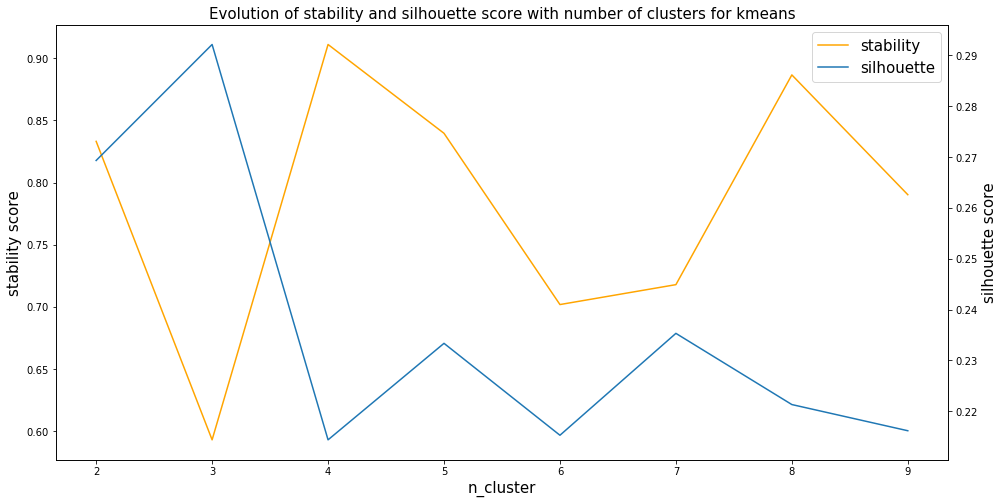

In [496]:
plt.figure(figsize=(16,8))
plt1, = plt.plot(n_cluster, L_stab, c='orange')
plt.xlabel("n_cluster", fontsize=15)
plt.ylabel("stability score", fontsize=15)
plt2, = plt.twinx().plot(n_cluster, L_sil)
plt.ylabel("silhouette score", fontsize=15)
plt.legend([plt1, plt2], ["stability","silhouette"], fontsize=15)
plt.title("Evolution of stability and silhouette score with number of clusters for kmeans", 
          fontsize=15)
plt.show()

For Kmeans, I tuned the number of clusters by looking at the silhouette score, the stability score and the shape of silhouette plots. I considered 2,3,4,5,7 and 9 clusters successively. Having 4 clusters seems the best choice, with the highest stability score and a good silhouette plot shape. 

### Agglomerative Clustering

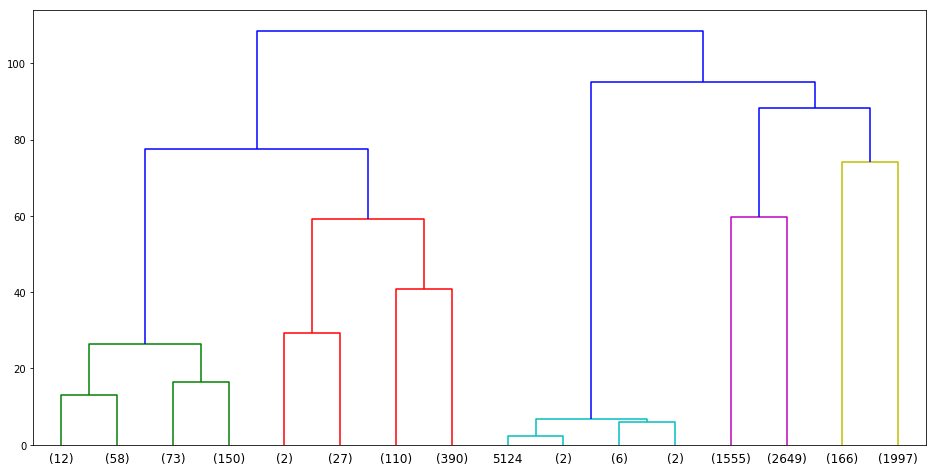

In [41]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
Z = linkage(X_scaled, 'ward')
plt.figure(figsize=(16,8))
dendrogram(Z, p=3, truncate_mode='level')
plt.show()

In [43]:
agg = AgglomerativeClustering(n_clusters=5,linkage='ward')
agg.fit(X_scaled)

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
            connectivity=None, linkage='ward', memory=None, n_clusters=5,
            pooling_func=<function mean at 0x1133c37b8>)

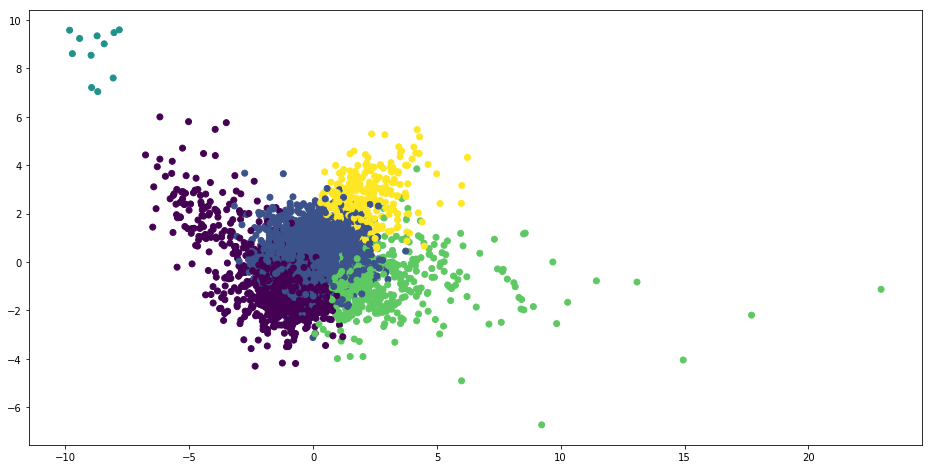

In [45]:
plt.figure(figsize=(16,8))
plt.scatter(X_pca[:,0], X_pca[:,1], c=agg.labels_)
plt.show()

CPU times: user 4min 42s, sys: 32.3 s, total: 5min 14s
Wall time: 6min


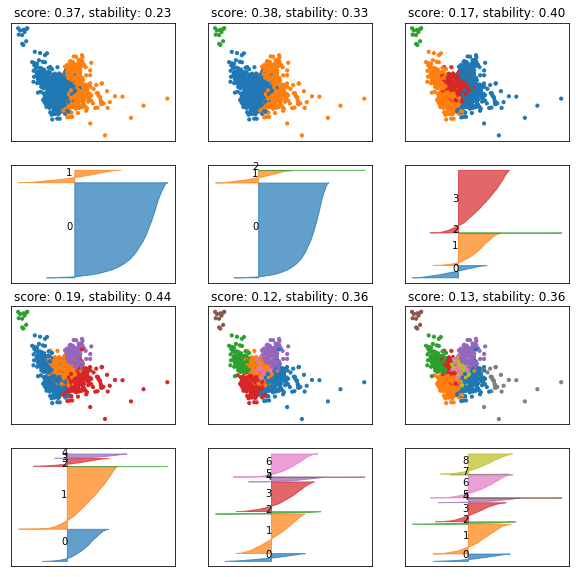

In [113]:
%%time
fig, axes = plt.subplots(4, 3, subplot_kw={'xticks': (), 'yticks':()}, figsize=(10, 10))
axes = np.hstack([axes[:2], axes[2:]]).T
for ax, i in zip(axes, [2,3,4,5,7,9]):
    agg = AgglomerativeClustering(n_clusters=i)
    agg.fit(X_scaled)
    ax[0].scatter(X_pca[:, 0], X_pca[:, 1], c=plt.cm.Vega10(agg.labels_), s=10)
    silhouette_plot(X_scaled, agg.labels_, ax=ax[1])
    ax[0].set_title("score: {:.2f}, stability: {:.2f}".format(silhouette_score(X_scaled, 
                                                                               agg.labels_), 
            cluster_stability(X_scaled, AgglomerativeClustering(n_clusters=i), n_iter=20)))

In [115]:
%%time
L_stab = []
L_sil = []
n_cluster = np.arange(2, 10, 1)
for i in n_cluster:
    agg = AgglomerativeClustering(n_clusters=i)
    L_stab.append(cluster_stability(X_scaled, agg))
    agg.fit(X_scaled)
    L_sil.append(silhouette_score(X_scaled, agg.labels_))

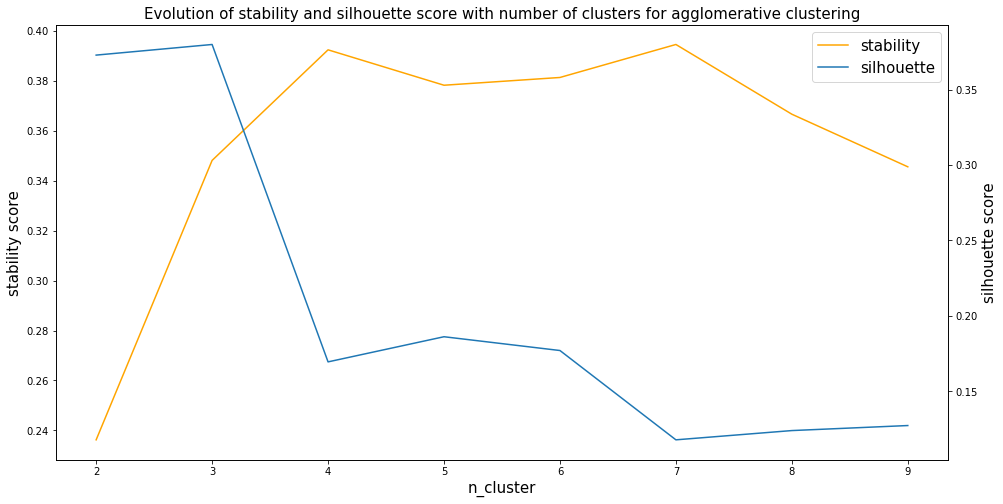

In [117]:
plt.figure(figsize=(16,8))
plt1, = plt.plot(n_cluster, L_stab, c='orange')
plt.xlabel("n_cluster", fontsize=15)
plt.ylabel("stability score", fontsize=15)
plt2, = plt.twinx().plot(n_cluster, L_sil)
plt.ylabel("silhouette score", fontsize=15)
plt.legend([plt1, plt2], ["stability","silhouette"], fontsize=15)
plt.title("Evolution of stability and silhouette score with number of clusters for agglomerative clustering",
          fontsize=15)
plt.show()

For Agglomerative Clustering, I first took a look on the dendogram. It shows that five clusters seems to be a natural choice. I checked the silhouette score, the stability score and the shape of the silhouette to strengthen this idea. However, one class contains only 11 points, but it is justified by the dendogram. This class is far from others and will merge only when three clusters will be still there.

### DBSCAN

CPU times: user 4min 39s, sys: 24.5 s, total: 5min 4s
Wall time: 5min 4s


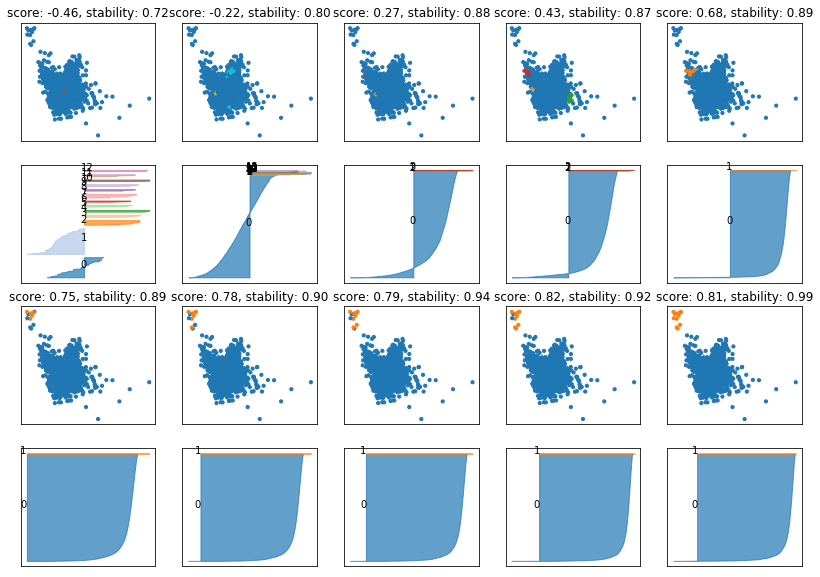

In [499]:
%%time
fig, axes = plt.subplots(4, 5, subplot_kw={'xticks': (), 'yticks':()}, figsize=(14, 10))
axes = np.hstack([axes[:2], axes[2:]]).T
for ax, epsilon in zip(axes, np.linspace(0.1,4,12)):
    db = DBSCAN(eps=epsilon)
    db.fit(X_scaled)
    ax[0].scatter(X_pca[:, 0], X_pca[:, 1], c=plt.cm.Vega10(db.labels_), s=10)
    silhouette_plot(X_scaled, db.labels_, ax=ax[1])
    ax[0].set_title("score: {:.2f}, stability: {:.2f}".format(silhouette_score(X_scaled, 
                                                                               db.labels_), 
                             cluster_stability(X_scaled, DBSCAN(eps=epsilon), n_iter=20)))

In [500]:
%%time
L_stab = []
L_sil = []
epsilon = np.linspace(0.1, 2, 10)
for eps in epsilon:
    db = DBSCAN(eps=eps)
    L_stab.append(cluster_stability(X_scaled, db))
    db.fit(X_scaled)
    L_sil.append(silhouette_score(X_scaled, db.labels_))

CPU times: user 3min 18s, sys: 10 s, total: 3min 28s
Wall time: 3min 29s


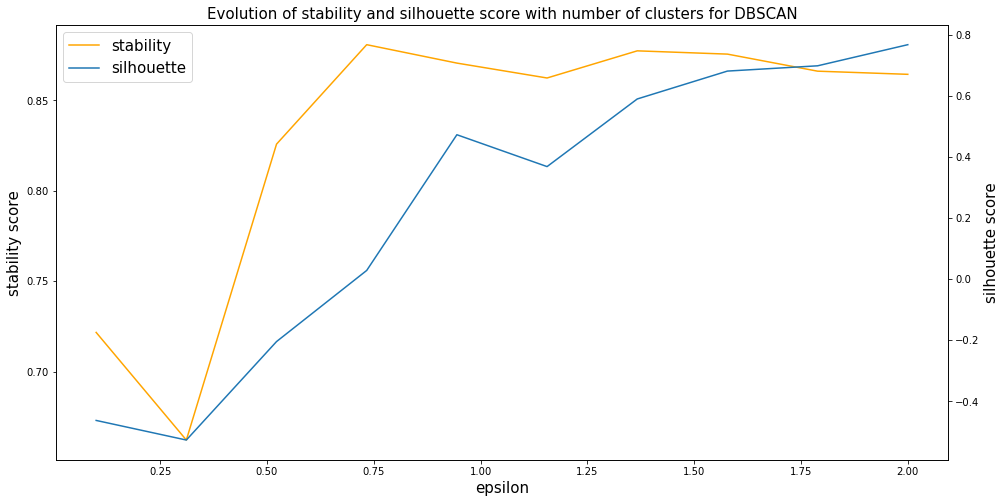

In [501]:
plt.figure(figsize=(16,8))
plt1, = plt.plot(epsilon, L_stab, c='orange')
plt.xlabel("epsilon", fontsize=15)
plt.ylabel("stability score", fontsize=15)
plt2, = plt.twinx().plot(epsilon, L_sil)
plt.ylabel("silhouette score", fontsize=15)
plt.legend([plt1, plt2], ["stability","silhouette"], fontsize=15)
plt.title("Evolution of stability and silhouette score with number of clusters for DBSCAN", 
          fontsize=15)
plt.show()

Same idea for DBSCAN, but this time the parameter is epsilon (min_samples=5). Choosing epsilon over 1 leads to 2 clusters with high silhouette score and stability score, and good silhouette plot profile.

## 2)

In [503]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(X_scaled)
agg = AgglomerativeClustering(n_clusters=5, linkage='ward')
agg.fit(X_scaled)
db = DBSCAN(eps=4)
db.fit(X_scaled)
ari_km = adjusted_rand_score(Y.ravel(), kmeans.labels_)
nmi_km = normalized_mutual_info_score(Y.ravel(), kmeans.labels_)
ari_agg = adjusted_rand_score(Y.ravel(), agg.labels_)
nmi_agg = normalized_mutual_info_score(Y.ravel(), agg.labels_)
ari_db = adjusted_rand_score(Y.ravel(), db.labels_)
nmi_db = normalized_mutual_info_score(Y.ravel(), db.labels_)

print("Kmeans:\nARI=",ari_km,"\nNMI=",nmi_km)
print("Agglomerative Clustering:\nARI=",ari_agg,"\nNMI=",nmi_agg)
print("DBSCAN:\nARI=",ari_db,"\nNMI=",nmi_db)

Kmeans:
ARI= 0.00165943664026 
NMI= 0.0484119613446
Agglomerative Clustering:
ARI= 0.0184509869462 
NMI= 0.0369069527761
DBSCAN:
ARI= 0.0321198300392 
NMI= 0.0558844642201


All three clusters performed poorly. It seems that inliers and outliers are intricated, and these three unsupervised clustering methods tend to consider them in the same cluster, whatever hyperparamaters are used. 

# Task 3

## 1)

In [489]:
from sklearn.covariance import EllipticEnvelope
ee = EllipticEnvelope(contamination=Y.sum()/len(Y))
ee.fit(X_scaled)
pred = ee.predict(X_pca)
pred_ee = (pred-1)//(-2)

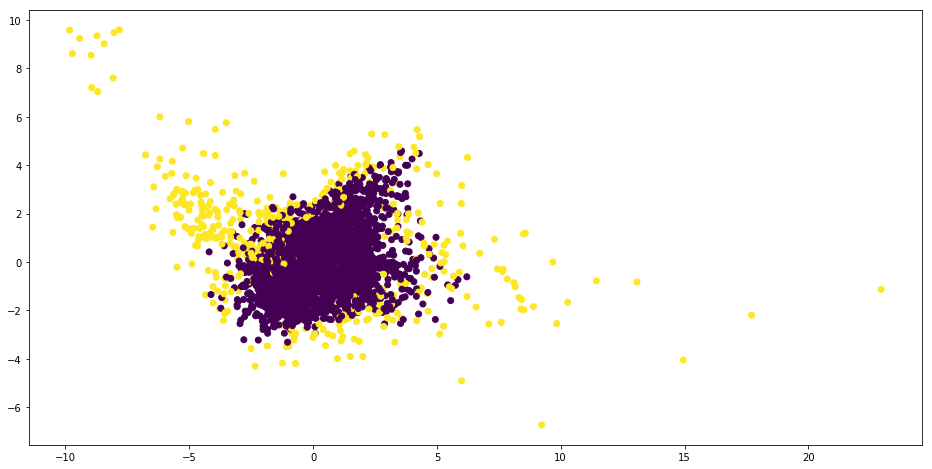

In [487]:
plt.figure(figsize=(16,8))
plt.scatter(X_pca[:,0], X_pca[:,1],c=pred_ee)
plt.show()

In [479]:
from sklearn.svm import OneClassSVM
oneclass = OneClassSVM(nu=Y.sum()/len(Y)).fit(X_scaled)
pred = oneclass.predict(X_scaled)
pred_one = (pred-1)//(-2)

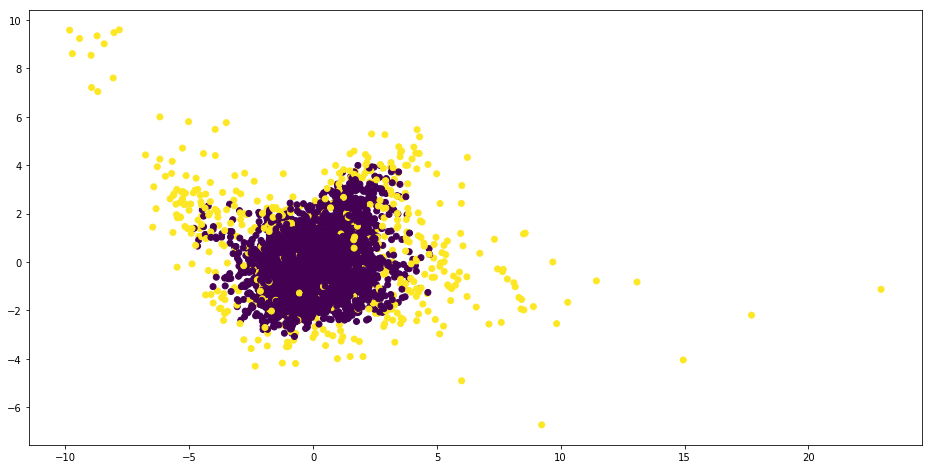

In [480]:
plt.figure(figsize=(16,8))
plt.scatter(X_pca[:,0], X_pca[:,1],c=pred_one)
plt.show()

In [481]:
from sklearn.ensemble import IsolationForest
iso_forest = IsolationForest(contamination=Y.sum()/len(Y))
iso_forest.fit(X_scaled)
pred = iso_forest.predict(X_scaled)
pred_iso = (pred-1)//(-2)

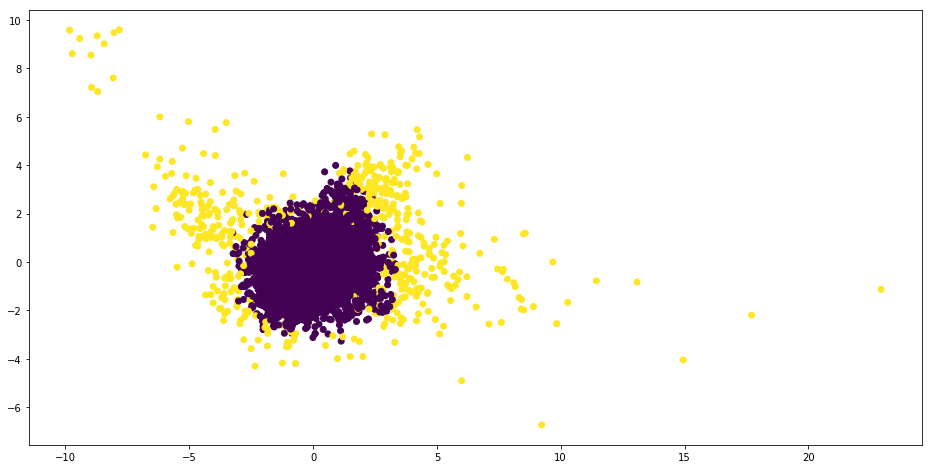

In [482]:
plt.figure(figsize=(16,8))
plt.scatter(X_pca[:,0], X_pca[:,1],c=pred_iso)
plt.show()

In [488]:
print(silhouette_score(X_scaled, pred_ee))
print(silhouette_score(X_scaled, pred_one))
print(silhouette_score(X_scaled, pred_iso))

0.475453361856
0.510605268182
0.535394639798


In [502]:
pred_iso.sum()

534

Without using ground truth, we can tell that Eliptic Envelope gave the best result by looking at the PCA projection of the data (n_components=2). Both OneClassSVM and IsolationForest are resulting in an inlier cluster too dense while Eliptic Envelope one is more intricated in the outlier cluster. That's what Task 2 told us, that outliers and inliers are intricated. 

## 2)

In [285]:
print(roc_auc_score((-(Y.ravel()-1)), ee.decision_function(X_scaled)))
print(roc_auc_score((-(Y.ravel()-1)), oneclass.decision_function(X_scaled)))
print(roc_auc_score((-(Y.ravel()-1)), iso_forest.decision_function(X_scaled)))

0.918494377528
0.564595504494
0.829075885117


In [286]:
print(average_precision_score((-(Y.ravel()-1)), ee.decision_function(X_scaled)))
print(average_precision_score((-(Y.ravel()-1)), oneclass.decision_function(X_scaled)))
print(average_precision_score((-(Y.ravel()-1)), iso_forest.decision_function(X_scaled)))

0.993114650343
0.916941764312
0.98375933034


Compared to Task2 estimators, their performance is much better, especially the EllipticEnvelope. 

# Task 4

In [406]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, stratify=Y)

In [407]:
def scorer(reg, X, Y):
    return min([roc_auc_score(Y, reg.predict_proba(X)[:,1]), 
                average_precision_score(Y, reg.predict_proba(X)[:,1])])

### Logistic Regression

In [408]:
%%time
pipe_reg = Pipeline([('scaler', StandardScaler()), 
                 ('regressor', LogisticRegression())])
param = {'regressor__C': np.logspace(-3,5,9)}
grid = GridSearchCV(pipe_reg,
                    param_grid=param,
                    scoring=scorer,
                    cv=10, 
                    verbose=True)
grid.fit(X_train, Y_train.ravel())

Fitting 10 folds for each of 9 candidates, totalling 90 fits
CPU times: user 3.05 s, sys: 59.1 ms, total: 3.11 s
Wall time: 1.64 s


[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:    1.6s finished


In [409]:
grid.best_params_

{'regressor__C': 10000.0}

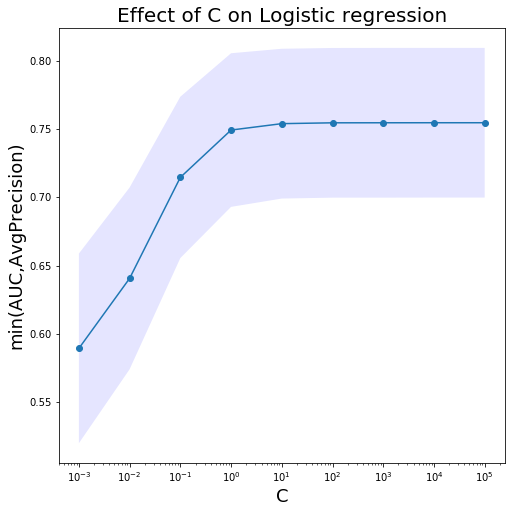

In [410]:
plt.figure(figsize=(8,8))
plt.xscale('log')
plt.title('Effect of C on Logistic regression', fontsize=20)
plt.xlabel('C', fontsize=18)
plt.ylabel('min(AUC,AvgPrecision)', fontsize=18)
plt.plot(param['regressor__C'], grid.cv_results_['mean_test_score'], marker='o')
plt.fill_between(param['regressor__C'], grid.cv_results_['mean_test_score'] 
                 + grid.cv_results_['std_test_score'], 
                 grid.cv_results_['mean_test_score'] - 
                 grid.cv_results_['std_test_score'], 
                 facecolor='blue', 
                 alpha=0.1)
plt.show()

In [411]:
logistic_reg = LogisticRegression(C=grid.best_params_['regressor__C'])
logistic_reg.fit(X_train, Y_train.ravel())

LogisticRegression(C=10000.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [412]:
print("AUC:", roc_auc_score(Y_test.ravel(), logistic_reg.predict_proba(X_test)[:,1]))
print("AvgPrecision:", average_precision_score(Y_test.ravel(), 
                                               logistic_reg.predict_proba(X_test)[:,1]))

AUC: 0.979229717966
AvgPrecision: 0.811155236839


### Random Forest

In [413]:
%%time
param_forest = {'max_leaf_nodes': [100,200,300,400,500],
                'max_depth': [3,5,7,9],
                'min_samples_leaf': [1,2,3,4]}
grid_forest = GridSearchCV(RandomForestClassifier(),
                    param_grid=param_forest,
                    scoring=scorer,
                    n_jobs=-1,
                    cv=10, 
                    verbose=True)
grid_forest.fit(X_train, Y_train.ravel())

Fitting 10 folds for each of 80 candidates, totalling 800 fits


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 376 tasks      | elapsed:    9.1s


CPU times: user 1.53 s, sys: 134 ms, total: 1.67 s
Wall time: 19 s


[Parallel(n_jobs=-1)]: Done 800 out of 800 | elapsed:   18.7s finished


In [414]:
print(grid_forest.best_params_)
print("Best cv score obtained:", grid_forest.best_score_)

{'max_depth': 7, 'max_leaf_nodes': 500, 'min_samples_leaf': 2}
Best cv score obtained: 0.928840709881


In [415]:
forest = RandomForestClassifier(max_leaf_nodes=grid_forest.best_params_['max_leaf_nodes'],
                                max_depth=grid_forest.best_params_['max_depth'],
                                min_samples_leaf=grid_forest.best_params_['min_samples_leaf'])
forest.fit(X_train, Y_train.ravel())

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=7, max_features='auto', max_leaf_nodes=500,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [416]:
print("AUC:", roc_auc_score(Y_test.ravel(), forest.predict_proba(X_test)[:,1]))
print("AvgPrecision:", average_precision_score(Y_test.ravel(), 
                                               forest.predict_proba(X_test)[:,1]))

AUC: 0.99708178665
AvgPrecision: 0.954482457439


### Using balanced class-weight 

In [417]:
%%time
pipe_reg_balanced = Pipeline([('scaler', StandardScaler()), 
                 ('regressor', LogisticRegression(class_weight="balanced"))])
param = {'regressor__C': np.logspace(-3,5,9)}
grid_balanced = GridSearchCV(pipe_reg_balanced,
                    param_grid=param,
                    scoring=scorer,
                    cv=10, 
                    verbose=True)
grid_balanced.fit(X_train, Y_train.ravel())

Fitting 10 folds for each of 9 candidates, totalling 90 fits
CPU times: user 3.59 s, sys: 83.5 ms, total: 3.67 s
Wall time: 2.25 s


[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:    2.2s finished


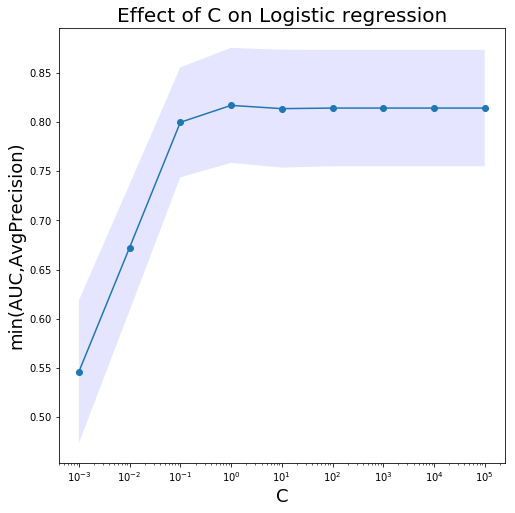

In [418]:
plt.figure(figsize=(8,8))
plt.xscale('log')
plt.title('Effect of C on Logistic regression', fontsize=20)
plt.xlabel('C', fontsize=18)
plt.ylabel('min(AUC,AvgPrecision)', fontsize=18)
plt.plot(param['regressor__C'], grid_balanced.cv_results_['mean_test_score'], marker='o')
plt.fill_between(param['regressor__C'], grid_balanced.cv_results_['mean_test_score'] 
                 + grid_balanced.cv_results_['std_test_score'], 
                 grid_balanced.cv_results_['mean_test_score'] - 
                 grid_balanced.cv_results_['std_test_score'], 
                 facecolor='blue', 
                 alpha=0.1)
plt.show()

In [425]:
logistic_reg_balanced = LogisticRegression(C=grid_balanced.best_params_['regressor__C'],
                                           class_weight="balanced")
logistic_reg_balanced.fit(X_train, Y_train.ravel())

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [426]:
print("AUC:", roc_auc_score(Y_test.ravel(), logistic_reg_balanced.predict_proba(X_test)[:,1]))
print("AvgPrecision", average_precision_score(Y_test.ravel(), 
                                              logistic_reg_balanced.predict_proba(X_test)[:,1]))

AUC: 0.855117698265
AvgPrecision 0.50404943551


In [421]:
%%time
param_forest = {'max_leaf_nodes': [100,200,300,400,500],
                'max_depth': [3,5,7,9],
                'min_samples_leaf': [1,2,3,4]}
grid_forest_balanced = GridSearchCV(RandomForestClassifier(class_weight="balanced"),
                    param_grid=param_forest,
                    scoring=scorer,
                    n_jobs=-1,
                    cv=10, 
                    verbose=True)
grid_forest_balanced.fit(X_train, Y_train.ravel())

Fitting 10 folds for each of 80 candidates, totalling 800 fits


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 376 tasks      | elapsed:    7.8s


CPU times: user 1.52 s, sys: 139 ms, total: 1.65 s
Wall time: 17.1 s


[Parallel(n_jobs=-1)]: Done 800 out of 800 | elapsed:   16.7s finished


In [422]:
print(grid_forest_balanced.best_params_)
print("Best cv score obtained:", grid_forest_balanced.best_score_)

{'max_depth': 9, 'max_leaf_nodes': 400, 'min_samples_leaf': 4}
Best cv score obtained: 0.924748532875


In [427]:
forest_balanced = RandomForestClassifier(max_leaf_nodes=grid_forest_balanced.best_params_['max_leaf_nodes'],
                                max_depth=grid_forest_balanced.best_params_['max_depth'],
                                min_samples_leaf=grid_forest_balanced.best_params_['min_samples_leaf'], 
                                class_weight="balanced")
forest_balanced.fit(X_train, Y_train.ravel())

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=9, max_features='auto',
            max_leaf_nodes=400, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=4,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [428]:
print("AUC:", roc_auc_score(Y_test.ravel(), forest_balanced.predict_proba(X_test)[:,1]))
print("AvgPrecision", average_precision_score(Y_test.ravel(), 
                                              forest_balanced.predict_proba(X_test)[:,1]))

AUC: 0.996729977313
AvgPrecision 0.948415882766


I got much better results with supervised method (Logistic Regression and RandomForest) than any of the three unsupervised could get. Howevever, using a "balanced" class weight did not help, especially in Logistic Regression where the AvgPrecision collapsed from 0.81 to 0.50.